Import the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Import the Dataset

In [3]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Quick EDA for Spam Detection

label
ham     4825
spam     747
Name: count, dtype: int64


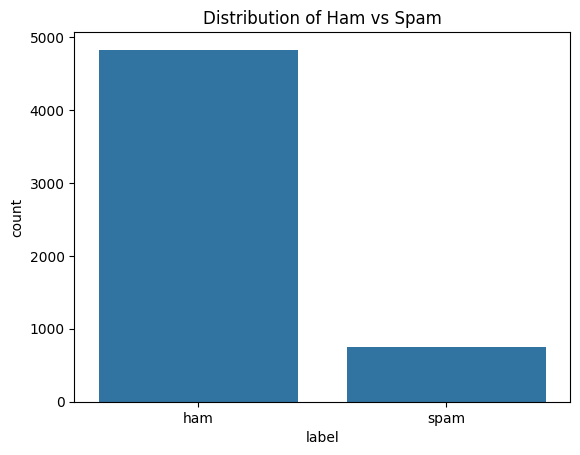

In [5]:
# 1. Class distribution
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.title("Distribution of Ham vs Spam")
plt.show()

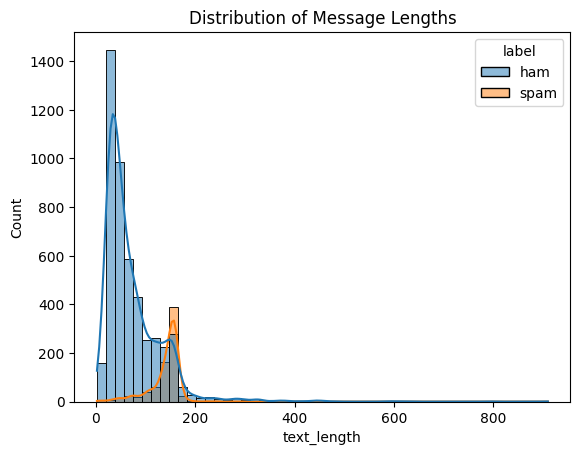

In [6]:
# 2. Text length analysis
df['text_length'] = df['Text'].apply(len)
sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
plt.title("Distribution of Message Lengths")
plt.show()

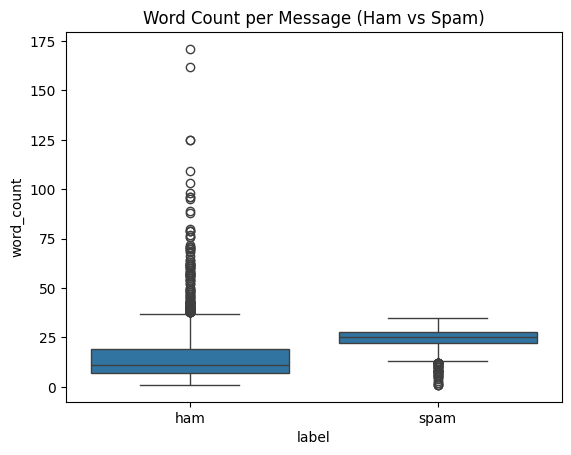

In [7]:
# 3. Word count analysis
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))
sns.boxplot(x='label', y='word_count', data=df)
plt.title("Word Count per Message (Ham vs Spam)")
plt.show()

In [8]:
# 4. Check duplicates
print("Duplicates:", df.duplicated().sum())

# 5. Check missing values
print("Missing values:\n", df.isnull().sum())

Duplicates: 415
Missing values:
 label          0
Text           0
label_enc      0
text_length    0
word_count     0
dtype: int64


In [13]:
# 6. Drop the duplicates
df = df.drop_duplicates()


Step 2: Text Preprocessing

In [14]:
import re
import string
import nltk
from nltk.corpus import stopwords

# Download stopwords (only first time)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Apply cleaning
df['clean_text'] = df['Text'].apply(preprocess_text)
df[['Text', 'clean_text']].head(10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipython-input-2322673586.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['Text'].apply(preprocess_text)


,Text,clean_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling weeks word back id like fu...
6,Even my brother is not like to speak with me. ...,even brother like speak treat like aids patent
7,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...
8,WINNER!! As a valued network customer you have...,winner valued network customer selected receiv...
9,Had your mobile 11 months or more? U R entitle...,mobile months u r entitled update latest colou...


Step 3: Feature Engineering (Convert Text → Numbers)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)  # limit features to avoid overfitting
X = tfidf.fit_transform(df['clean_text']).toarray()

# Labels
y = df['label_enc'].values

print("Feature matrix shape:", X.shape)


Feature matrix shape: (5157, 5000)


Step 4: Train-Test Split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)


Training size: (4125, 5000)
Testing size: (1032, 5000)


Step 6: Baseline Model (Naive Bayes)

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train baseline model
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predictions
y_pred = nb.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9689922480620154

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       904
           1       1.00      0.75      0.86       128

    accuracy                           0.97      1032
   macro avg       0.98      0.88      0.92      1032
weighted avg       0.97      0.97      0.97      1032


Confusion Matrix:
 [[904   0]
 [ 32  96]]


Step 7: Classical ML Models

In [18]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Helper function to evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name} Results:")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

# Train & Evaluate Models
results = []

# 1. Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
results.append(evaluate_model("Logistic Regression", lr_model, X_train, y_train, X_test, y_test))

# 2. Support Vector Machine (LinearSVC)
svm_model = LinearSVC()
results.append(evaluate_model("SVM (Linear)", svm_model, X_train, y_train, X_test, y_test))

# 3. Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
results.append(evaluate_model("Random Forest", rf_model, X_train, y_train, X_test, y_test))

# Convert results to DataFrame for comparison
import pandas as pd
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df)



Logistic Regression Results:
Accuracy: 0.9525193798449613
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       904
           1       0.96      0.64      0.77       128

    accuracy                           0.95      1032
   macro avg       0.96      0.82      0.87      1032
weighted avg       0.95      0.95      0.95      1032

Confusion Matrix:
 [[901   3]
 [ 46  82]]

SVM (Linear) Results:
Accuracy: 0.9738372093023255
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       904
           1       0.97      0.81      0.89       128

    accuracy                           0.97      1032
   macro avg       0.97      0.90      0.94      1032
weighted avg       0.97      0.97      0.97      1032

Confusion Matrix:
 [[901   3]
 [ 24 104]]

Random Forest Results:
Accuracy: 0.9670542635658915
Classification Report:
               precision   

Step 8: Deep Learning Models

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Train-test split on clean text (not TF-IDF)
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    df["clean_text"], df["label_enc"],
    test_size=0.2, random_state=42, stratify=df["label_enc"]
)

# Convert to numpy arrays of strings for TensorFlow compatibility
X_train_dl = X_train_dl.astype(str).to_numpy()
X_test_dl  = X_test_dl.astype(str).to_numpy()
y_train_dl = y_train_dl.to_numpy()
y_test_dl  = y_test_dl.to_numpy()

# Text vectorization
MAX_TOKENS = 20000   # max vocabulary size
OUTPUT_LEN = 100     # sequence length

text_vectorizer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=OUTPUT_LEN
)

# Adapt vectorizer on training data only
text_vectorizer.adapt(X_train_dl)


8.1  Model 1: Embedding + Dense

In [22]:
# Define model
embedding_model = keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    layers.Embedding(input_dim=MAX_TOKENS, output_dim=128),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

embedding_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Train
history_emb = embedding_model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_test_dl, y_test_dl),
    epochs=5,
    batch_size=32
)


Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8760 - loss: 0.3917 - val_accuracy: 0.8760 - val_loss: 0.3546
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8769 - loss: 0.3484 - val_accuracy: 0.8760 - val_loss: 0.3334
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8831 - loss: 0.3105 - val_accuracy: 0.8760 - val_loss: 0.2714
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8922 - loss: 0.2349 - val_accuracy: 0.9312 - val_loss: 0.1613
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9536 - loss: 0.1348 - val_accuracy: 0.9738 - val_loss: 0.1050


8.2 Model 2: BiLSTM

In [23]:
# Define BiLSTM model
bilstm_model = keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    layers.Embedding(input_dim=MAX_TOKENS, output_dim=128),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

bilstm_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Train
history_lstm = bilstm_model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_test_dl, y_test_dl),
    epochs=5,
    batch_size=32
)


Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 48s 309ms/step - accuracy: 0.8761 - loss: 0.3097 - val_accuracy: 0.9719 - val_loss: 0.0823
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 293ms/step - accuracy: 0.9907 - loss: 0.0407 - val_accuracy: 0.9767 - val_loss: 0.0708
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 303ms/step - accuracy: 0.9952 - loss: 0.0178 - val_accuracy: 0.9806 - val_loss: 0.0669
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 296ms/step - accuracy: 0.9977 - loss: 0.0085 - val_accuracy: 0.9845 - val_loss: 0.0891
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 0.9845 - val_loss: 0.0846


8.3 Evaluation Function for All Models

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_dl_model(model, X_test, y_test, name):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-score": f1}

# Evaluate all models
dl_results = []
dl_results.append(evaluate_dl_model(embedding_model, X_test_dl, y_test_dl, "Embedding + Dense"))
dl_results.append(evaluate_dl_model(bilstm_model, X_test_dl, y_test_dl, "BiLSTM"))

# Compare results
import pandas as pd
results_df = pd.DataFrame(dl_results)
print("\n=== Deep Learning Model Comparison ===")
print(results_df)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Embedding + Dense Results:
Accuracy: 0.9738, Precision: 0.9810, Recall: 0.8047, F1: 0.8841
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step

BiLSTM Results:
Accuracy: 0.9845, Precision: 0.9746, Recall: 0.8984, F1: 0.9350

=== Deep Learning Model Comparison ===
               Model  Accuracy  Precision    Recall  F1-score
0  Embedding + Dense  0.973837   0.980952  0.804688  0.884120
1             BiLSTM  0.984496   0.974576  0.898438  0.934959


Step 9: Model Comparison & Visualization

In [33]:

final_results = pd.concat(
    [results_df, pd.DataFrame(dl_results)],
    ignore_index=True
)

print("\n=== Final Model Comparison ===")
print(final_results)

# Optional: save to CSV
final_results.to_csv("final_model_results.csv", index=False)



=== Final Model Comparison ===
               Model  Accuracy  Precision    Recall  F1-score
0  Embedding + Dense  0.973837   0.980952  0.804688  0.884120
1             BiLSTM  0.984496   0.974576  0.898438  0.934959
2  Embedding + Dense  0.973837   0.980952  0.804688  0.884120
3             BiLSTM  0.984496   0.974576  0.898438  0.934959


9.1 Plot Comparison Metrics

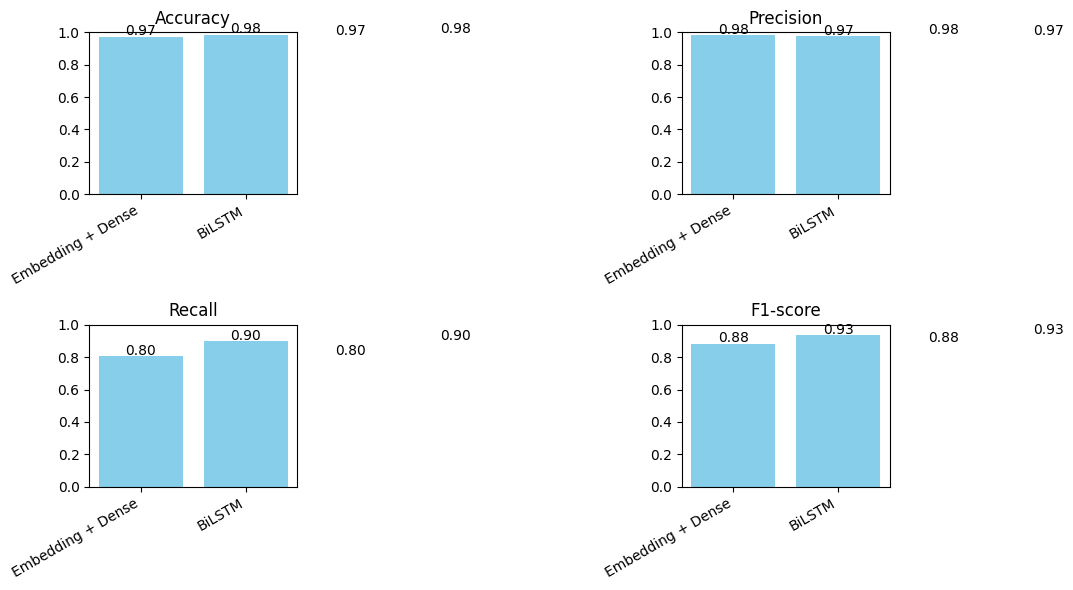

In [34]:
# Use combined results for plotting
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(12,6))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    plt.bar(final_results["Model"], final_results[metric], color="skyblue")
    plt.title(metric)
    plt.xticks(rotation=30, ha="right")
    plt.ylim(0, 1)
    for idx, val in enumerate(final_results[metric]):
        plt.text(idx, val+0.01, f"{val:.2f}", ha="center")
plt.tight_layout()
plt.show()


9.2: Plot Training History

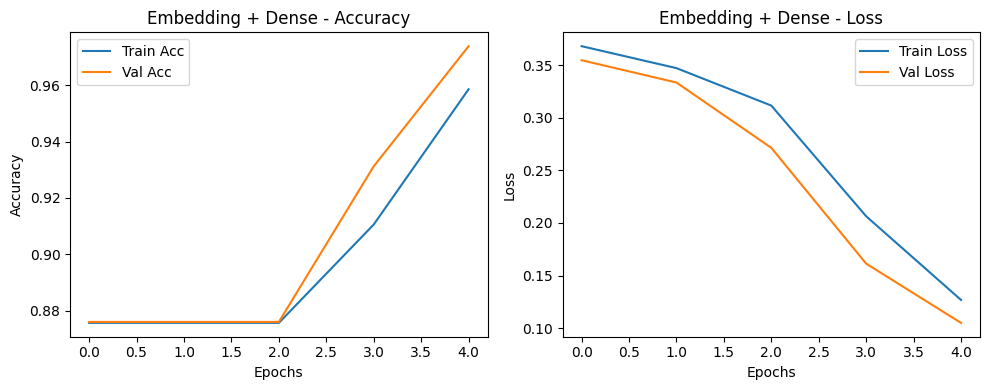

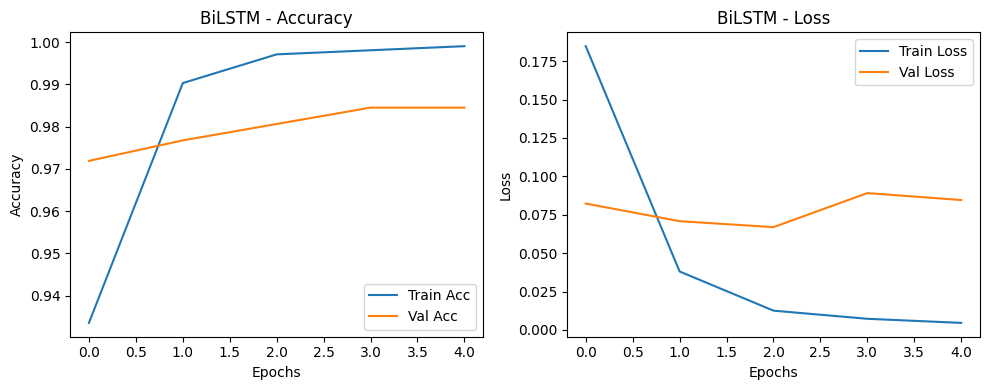

In [32]:
# Helper function to plot training history
def plot_history(history, title):
    plt.figure(figsize=(10,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot histories for your deep learning models
plot_history(history_emb, "Embedding + Dense")
plot_history(history_lstm, "BiLSTM")


In [35]:
print("=== Conclusion ===")
print("""
Among all models:
- Naive Bayes: Strong baseline, ~97% accuracy, but recall for spam was lower.
- Logistic Regression & Random Forest: Good precision but recall suffered.
- SVM (Linear): Solid performance (97.4% accuracy), balanced precision-recall.
- Embedding + Dense: Matched SVM performance with ~97.3% accuracy.
- BiLSTM: Best model with ~98.4% accuracy and ~0.93 F1-score.
""")


=== Conclusion ===

Among all models:
- Naive Bayes: Strong baseline, ~97% accuracy, but recall for spam was lower.
- Logistic Regression & Random Forest: Good precision but recall suffered.
- SVM (Linear): Solid performance (97.4% accuracy), balanced precision-recall.
- Embedding + Dense: Matched SVM performance with ~97.3% accuracy.
- BiLSTM: Best model with ~98.4% accuracy and ~0.93 F1-score.



Step 10: Save Best Model

Since BiLSTM performed best, let’s save it.

In [36]:
import joblib

# Save TF-IDF vectorizer (needed if you want to use classical models later)
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

# Save DL model (BiLSTM)
bilstm_model.save("bilstm_spam_model.h5")

print("Models saved successfully!")


Models saved successfully!
